Ya hemos realizado un análisis exploratorio durante la primera parte del trabajo práctico. En este notebook se volverá a retomar dicho análisis para lograr conseguir un *preprocesamiento* de datos con mayor calidad de tal forma que nuestros modelos de aprendizaje automático que aplicaremos, puedan aprender mejor sobre el conjunto de datos a presentarles. Ademas no queremos que nos devuelvan basura. Tal como dice el refrán:

"**Garbage in... garbage out**"

Profundizaremos en diferentes técnicas de la *Ingeniería de Features* que no hemos tratado en la primera parte del trabajo práctico y nos será de muchísima utilidad para la hora de exportar nuestros preprocesamientos en el fichero **preprocessing.py** solicitado. 

In [1]:
from functools import lru_cache
import dtreeviz.trees as dtreeviz
import graphviz
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
import ipywidgets as widgets
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ParameterGrid
from sklearn.decomposition import TruncatedSVD
import seaborn as sns
import pandas as pd
from IPython.display import SVG, display
from ipywidgets import Button, IntSlider, interactive
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from sklearn import preprocessing, tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import (
    KBinsDiscretizer,
    MinMaxScaler,
    Normalizer,
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
)
from sklearn.model_selection import StratifiedShuffleSplit, KFold, StratifiedKFold
sns.set()

from preprocessing import obtener_datasets
from preprocessing import aplicar_preparacion
from preprocessing import graficar_matriz_confusion
from preprocessing import conversion_numerica

# Buscando reducir dimensionalidad

## Busquemos reducir dimensionalidad con algún escalado de los datos

Definamos la siguiente función que reduzca la dimensionalidad. Utilzaremos TruncatedSVD para reducir lo mismo el cual realiza una reducción via la descomposición de valores singulares.

**Chamuyar más sobre TruncatedSVD**

Pero antes de reducir la dimensionalidad, apliquemos diferentes escalado de los datos para saber cual reducción nos mantiene un mayor porcentaje de varianza.

In [2]:
def graficar_reducciones_con_preprocesamientos(df,var_deseada):
    scalers = [
        StandardScaler(),
        MinMaxScaler(),  
        RobustScaler(), 
        PowerTransformer(), 
        Normalizer(),
    ]

    fig, ax = plt.subplots(dpi=110)
    for count, scaler in enumerate(scalers):
        print("----------------------------------------------------------------------------")
        print("Buscando reducción de dimensionalidad con preprocesamiento de", scaler)

        scaled = scaler.fit_transform(df)
        X_df_scaled = pd.DataFrame(scaled, index=df.index, columns=df.columns)
        
        svd = TruncatedSVD(n_components=df.shape[1]-1, n_iter=10, random_state=10)
        svd.fit(X_df_scaled)

        var_cumu = np.cumsum(svd.explained_variance_ratio_) * 100
        k = np.argmax(var_cumu > var_deseada)
        
        print("El numero minimo de componentes para explicar el",var_deseada, "% de la varianza es: " + str(k))
        if count == 4:
            print("----------------------------------------------------------------------------\n")

        ax.set_title('Varianza acumulada explicada por componente')
        ax.set_ylabel('Varianza acumulada explicada')
        ax.set_xlabel('Componentes principales')
    
        axes = ax.plot(var_cumu, label = scaler)
        ax.legend()
        ax.axhline(y=85, color="r", linestyle="--")


----------------------------------------------------------------------------
Buscando reducción de dimensionalidad con preprocesamiento de StandardScaler()
El numero minimo de componentes para explicar el 95 % de la varianza es: 31
----------------------------------------------------------------------------
Buscando reducción de dimensionalidad con preprocesamiento de MinMaxScaler()
El numero minimo de componentes para explicar el 95 % de la varianza es: 22
----------------------------------------------------------------------------
Buscando reducción de dimensionalidad con preprocesamiento de RobustScaler()
El numero minimo de componentes para explicar el 95 % de la varianza es: 0
----------------------------------------------------------------------------
Buscando reducción de dimensionalidad con preprocesamiento de PowerTransformer()
El numero minimo de componentes para explicar el 95 % de la varianza es: 31
---------------------------------------------------------------------------

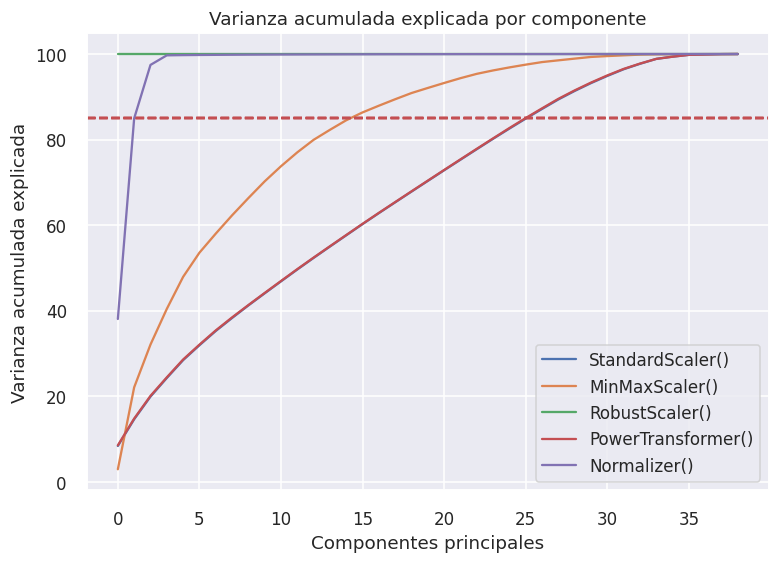

In [3]:
df, df_for_prediction = obtener_datasets()
X_df_r, y_df_r = aplicar_preparacion(df)
X_df_numerico = conversion_numerica(X_df_r) 

graficar_reducciones_con_preprocesamientos(X_df_numerico, 95)

Aquella transformación con la que logramos mantener un 95% de varianza es la MinMaxScaler() con un numero de componentes menor, de 23. 

**(DUDANDO)** Tiene sentido que con al Normalizer() hayamos obtenido solamente 2 componentes pues estan todos los valores normalizado. Si se piensa en un grafico 2D es como si se proyectase ese circulo unitario (formado gracias a una Normalización) sobre los ejes en 2 dimensiones, es decir, sobre 2 componentes principales de los ejes.


Nos quedaremos entonces con el escalado de los datos de *MinMaxScaler()* aplicando TruncatedSVD con 23 compoenntes a reducir. Definimos dicha función que dejaremos lista en el *preprocessing.py*

In [4]:
def reduccion_numerica(X_df, componentes_finales = 23):
    scaled = MinMaxScaler().fit_transform(X_df)
    X_df_numerico_scaled = pd.DataFrame(scaled, index=X_df_numerico.index, columns=X_df_numerico.columns)

    svd = TruncatedSVD(n_components=componentes_finales, n_iter=7, random_state=10)
    X_df_numerico_scaled_svd = pd.DataFrame(svd.fit_transform(X_df_numerico_scaled))
    print('TruncatedSVD con',  componentes_finales, 'componentes finales se explica una varianza de: %.10f' % svd.explained_variance_ratio_.sum())
    return X_df_numerico_scaled_svd

In [5]:
X_reducida = reduccion_numerica(X_df_numerico)

TruncatedSVD con 23 componentes finales se explica una varianza de: 0.9536277314


El cual podemos comprobar sus 23 componetes: 

In [6]:
X_reducida.shape

(32561, 23)

## Revisemos con t-SNE como quedó esta reducción

Puede tardar un poco por tratarse de muchos datos.

In [7]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init='pca', random_state=1001, perplexity=35, method='barnes_hut', n_iter=1000, verbose=1)
X_tsne = tsne.fit_transform(X_reducida)  

[t-SNE] Computing 106 nearest neighbors...
[t-SNE] Indexed 32561 samples in 0.093s...
[t-SNE] Computed neighbors for 32561 samples in 14.400s...
[t-SNE] Computed conditional probabilities for sample 1000 / 32561
[t-SNE] Computed conditional probabilities for sample 2000 / 32561
[t-SNE] Computed conditional probabilities for sample 3000 / 32561
[t-SNE] Computed conditional probabilities for sample 4000 / 32561
[t-SNE] Computed conditional probabilities for sample 5000 / 32561
[t-SNE] Computed conditional probabilities for sample 6000 / 32561
[t-SNE] Computed conditional probabilities for sample 7000 / 32561
[t-SNE] Computed conditional probabilities for sample 8000 / 32561
[t-SNE] Computed conditional probabilities for sample 9000 / 32561
[t-SNE] Computed conditional probabilities for sample 10000 / 32561
[t-SNE] Computed conditional probabilities for sample 11000 / 32561
[t-SNE] Computed conditional probabilities for sample 12000 / 32561
[t-SNE] Computed conditional probabilities for s

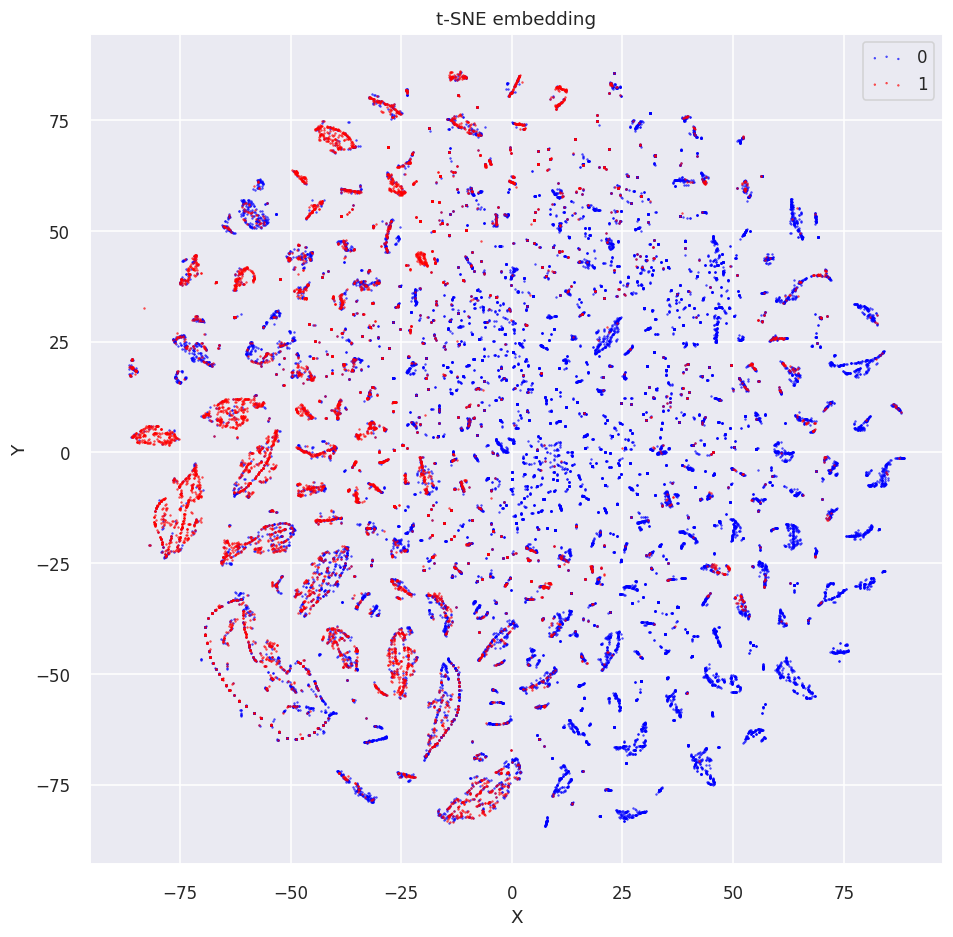

In [8]:
colors = ['blue', 'red']
target_names = np.unique(y_df_r)

plt.figure(2, figsize=(10, 10), dpi = 110)

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_tsne[y_df_r == i, 0], X_tsne[y_df_r == i, 1], color=color, s=1,
                alpha=.8, label=target_name, marker='.')
plt.legend(loc='best', shadow=False, scatterpoints=3)
plt.title('t-SNE embedding')
plt.xlabel('X')
plt.ylabel('Y')

plt.savefig('t-SNE_23_components', dpi=150)
plt.show()

## Ahora encontremos los clusters con dataset reducido

In [9]:
def obtener_mejor_hiperparametros_dbscan(df, min_samples_parameters, eps_parameters):
    """
        Lo comun:     
    * min_samples_parameters = [3,4,5,6,7,8]
    * eps_parameters = [0.1, 0.2, 0.3, 0.4]

    * df['cluster_dbscan'] = DBSCAN(algorithm='kd_tree', eps= 0.4, min_samples = 3).fit_predict(pca_result)

    """

    print("----------------------------------------------------------------------------")
    parameter_grid = ParameterGrid({'eps': eps_parameters, 'min_samples': min_samples_parameters})

    best_score = -1
    best_n_clusters = -1
    dbscan = DBSCAN(algorithm='kd_tree')    
    silhouette_scores = []

    for p in parameter_grid:
        dbscan.set_params(**p)
        dbscan.fit(df)

        ss = silhouette_score(df, dbscan.labels_)
        silhouette_scores += [ss]

        print('Parametros', p, 'Coeficiente Silhouette', ss)

        if ss > best_score:
            best_score = ss
            best_grid = p
            best_n_clusters = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)

    print("----------------------------------------------------------------------------")
    return best_grid, best_n_clusters

In [10]:
best_grid, n_clusters = obtener_mejor_hiperparametros_dbscan(X_reducida, [3,4,5,6,7,8], [0.1, 0.2, 0.3, 0.4])
best_grid, n_clusters

----------------------------------------------------------------------------
Parametros {'eps': 0.1, 'min_samples': 3} Coeficiente Silhouette 0.4111332832223522
Parametros {'eps': 0.1, 'min_samples': 4} Coeficiente Silhouette 0.4074844930786864
Parametros {'eps': 0.1, 'min_samples': 5} Coeficiente Silhouette 0.38694424345597506
Parametros {'eps': 0.1, 'min_samples': 6} Coeficiente Silhouette 0.385476952283603
Parametros {'eps': 0.1, 'min_samples': 7} Coeficiente Silhouette 0.36422786784540634
Parametros {'eps': 0.1, 'min_samples': 8} Coeficiente Silhouette 0.36952545215833943
Parametros {'eps': 0.2, 'min_samples': 3} Coeficiente Silhouette 0.6992678044846382
Parametros {'eps': 0.2, 'min_samples': 4} Coeficiente Silhouette 0.6836020617045004
Parametros {'eps': 0.2, 'min_samples': 5} Coeficiente Silhouette 0.6660455166103538
Parametros {'eps': 0.2, 'min_samples': 6} Coeficiente Silhouette 0.6472995630447975
Parametros {'eps': 0.2, 'min_samples': 7} Coeficiente Silhouette 0.63472057944777

({'eps': 0.4, 'min_samples': 3}, 968)

### Apliquemos OneHotEncoding para estas clusters

In [11]:
def one_hot_clusters_dbscan(X_reducida, eps, min_samples):
    """
    Recibe el 'X_reducida'
    """
    model = DBSCAN(algorithm='kd_tree', eps=eps, min_samples=min_samples)
    df = pd.DataFrame(X_reducida)
    df['cluster_dbscan'] = model.fit_predict(df)
    df = pd.get_dummies(df, drop_first=True, columns=['cluster_dbscan'])
    return df

In [12]:
X_df_numerico_scaled_svd_oe = one_hot_clusters_dbscan(X_reducida, 0.3, 3)

In [13]:
X_df_numerico_scaled_svd_oe.shape

(32561, 977)

# Busquemos expandir el dataset

In [14]:
df, df_for_prediction = obtener_datasets()
X_df_r, y_df_r = aplicar_preparacion(df)
X_df_numerico = conversion_numerica(X_df_r) 

----------------------------------------------------------------------------
Buscando reducción de dimensionalidad con preprocesamiento de StandardScaler()
El numero minimo de componentes para explicar el 95 % de la varianza es: 31
----------------------------------------------------------------------------
Buscando reducción de dimensionalidad con preprocesamiento de MinMaxScaler()
El numero minimo de componentes para explicar el 95 % de la varianza es: 22
----------------------------------------------------------------------------
Buscando reducción de dimensionalidad con preprocesamiento de RobustScaler()
El numero minimo de componentes para explicar el 95 % de la varianza es: 0
----------------------------------------------------------------------------
Buscando reducción de dimensionalidad con preprocesamiento de PowerTransformer()
El numero minimo de componentes para explicar el 95 % de la varianza es: 31
---------------------------------------------------------------------------

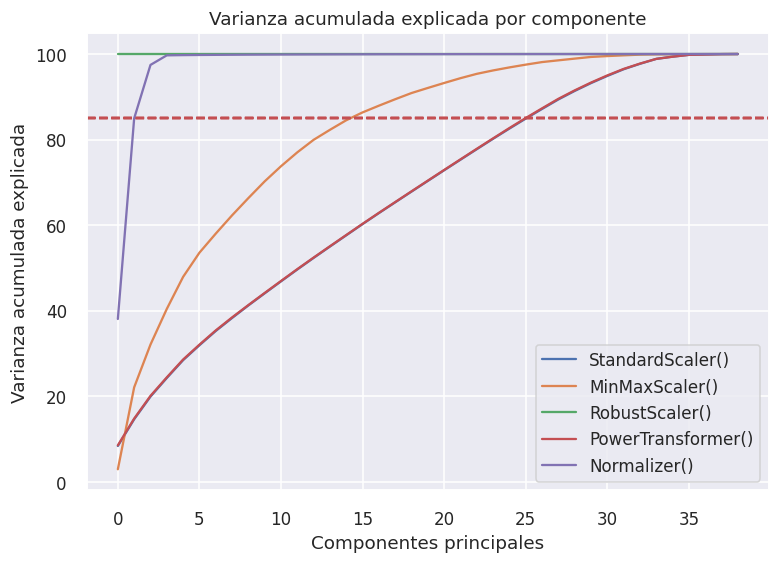

In [15]:
graficar_reducciones_con_preprocesamientos(X_df_numerico, 95)

In [16]:
scaled = MinMaxScaler().fit_transform(X_df_numerico)
X_df_numerico_scaled = pd.DataFrame(scaled, index=X_df_numerico.index, columns=X_df_numerico.columns)

svd = TruncatedSVD(n_components=23, n_iter=7, random_state=10)
X_df_numerico_scaled_svd = pd.DataFrame(svd.fit_transform(X_df_numerico_scaled))
print('Varianza explicada: %.10f' % svd.explained_variance_ratio_.sum())

Varianza explicada: 0.9536277314


In [17]:
X_df_numerico_scaled_svd.describe()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,...,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,1.757756,-0.009302,0.022503,-0.000170,0.015685,0.025937,0.000390,0.017447,0.016273,0.002179,...,0.007337,0.006512,0.000975,0.000538,-0.000643,0.005841,0.002259,0.001569,-0.000184,0.002893
std,0.286326,0.738024,0.533168,0.486707,0.461607,0.401001,0.355926,0.348584,0.338796,0.333479,...,0.257878,0.252401,0.228129,0.211148,0.207271,0.202858,0.183890,0.181632,0.178763,0.169727
min,0.369935,-1.072954,-0.903469,-1.166627,-1.078415,-0.902605,-0.695408,-0.803230,-0.505688,-0.936672,...,-0.551427,-0.825195,-0.769405,-0.910135,-0.927085,-0.415461,-0.744037,-0.769602,-0.511175,-0.784845
25%,1.556815,-0.766784,-0.409160,-0.324954,-0.172196,-0.202288,-0.261193,-0.141369,-0.240477,-0.159543,...,-0.147849,-0.115781,-0.082770,-0.054024,-0.078921,-0.112963,-0.068221,-0.060485,-0.075419,-0.043886
50%,1.819037,0.119531,-0.111545,-0.007936,0.000464,-0.034373,-0.032302,0.043610,-0.050856,0.061859,...,-0.059565,-0.017677,-0.025179,-0.008157,0.002382,-0.052311,-0.017264,-0.015700,-0.025596,-0.001798
75%,1.963624,0.652440,0.344363,0.221660,0.287612,0.115458,0.139525,0.222159,0.151062,0.195774,...,0.096027,0.131665,0.059712,0.041557,0.065114,0.024074,0.038162,0.032912,0.011186,0.038378
max,2.525975,1.369101,1.683246,1.662539,1.284397,1.614096,1.058258,1.050361,1.529796,0.938083,...,1.140963,1.169388,0.993490,1.108960,1.036885,1.245017,1.468622,1.350029,1.142547,1.044192


In [18]:
X_df_numerico_scaled_svd.var()

0     0.081982
1     0.544679
2     0.284268
3     0.236884
4     0.213081
5     0.160801
6     0.126684
7     0.121511
8     0.114783
9     0.111208
10    0.100560
11    0.092423
12    0.083211
13    0.066501
14    0.063706
15    0.052043
16    0.044583
17    0.042961
18    0.041151
19    0.033816
20    0.032990
21    0.031956
22    0.028807
dtype: float64

In [19]:
from sklearn.preprocessing import PolynomialFeatures

In [20]:
def get_dataframe_polynomial(df, grade_r, interaction_only_r):
    poly = PolynomialFeatures(grade_r, interaction_only = interaction_only_r)
    return pd.DataFrame(poly.fit_transform(df))  

In [21]:
X_df_numerico_poly = get_dataframe_polynomial(X_df_numerico_scaled_svd, 2, False)

In [22]:
X_df_numerico_poly.describe()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
count,32561.0,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,...,3.256100e+04,3.256100e+04,3.256100e+04,3.256100e+04,3.256100e+04,3.256100e+04,3.256100e+04,3.256100e+04,3.256100e+04,3.256100e+04
mean,1.0,1.757756,-0.009302,0.022503,-0.000170,0.015685,0.025937,0.000390,0.017447,0.016273,...,3.381974e-02,1.898505e-17,-3.055065e-17,3.383758e-17,3.299159e-02,7.637663e-18,-2.304938e-17,3.195528e-02,-4.020684e-17,2.881463e-02
std,0.0,0.286326,0.738024,0.533168,0.486707,0.461607,0.401001,0.355926,0.348584,0.338796,...,1.073626e-01,8.571085e-02,6.189640e-02,4.219552e-02,1.027857e-01,5.523846e-02,4.467148e-02,9.250722e-02,8.447989e-02,1.013265e-01
min,1.0,0.369935,-1.072954,-0.903469,-1.166627,-1.078415,-0.902605,-0.695408,-0.803230,-0.505688,...,6.439267e-12,-5.159941e-01,-5.642836e-01,-4.793549e-01,3.581924e-12,-4.825232e-01,-5.501613e-01,1.364504e-11,-7.487606e-01,2.576236e-15
25%,1.0,1.556815,-0.766784,-0.409160,-0.324954,-0.172196,-0.202288,-0.261193,-0.141369,-0.240477,...,6.753972e-04,-3.198660e-03,-1.862638e-03,-1.957187e-03,4.825054e-04,-3.157667e-03,-2.043770e-03,4.475236e-04,-1.889566e-03,3.482585e-04
50%,1.0,1.819037,0.119531,-0.111545,-0.007936,0.000464,-0.034373,-0.032302,0.043610,-0.050856,...,3.120195e-03,-2.784945e-04,1.710760e-04,1.121530e-07,2.388352e-03,-9.625744e-07,-1.284684e-04,2.664866e-03,-1.261272e-04,1.717721e-03
75%,1.0,1.963624,0.652440,0.344363,0.221660,0.287612,0.115458,0.139525,0.222159,0.151062,...,1.064898e-02,1.123158e-03,2.942185e-03,1.732803e-03,1.041346e-02,1.553780e-03,1.189524e-03,1.271007e-02,1.479970e-03,7.227741e-03
max,1.0,2.525975,1.369101,1.683246,1.662539,1.284397,1.614096,1.058258,1.050361,1.529796,...,2.156850e+00,6.109736e-01,1.102118e+00,8.873382e-01,1.822577e+00,1.040526e+00,9.423931e-01,1.305413e+00,9.301975e-01,1.090337e+00


Borro las features que me hayan quedado con variana zero:

In [23]:
from sklearn.feature_selection import VarianceThreshold

def filter_by_variance(df, threshold):
    cols_con_varianza = df.var().index.values
    _df = df[cols_con_varianza].copy()
    selector = VarianceThreshold(threshold=threshold)
    vt = selector.fit(_df)
    _df = _df.loc[:, vt.get_support()]
    return _df


X_df_numerico_poly = filter_by_variance(X_df_numerico_poly, 0)


In [24]:
X_df_numerico_poly.var()

1      0.081982
2      0.544679
3      0.284268
4      0.236884
5      0.213081
         ...   
295    0.003051
296    0.001996
297    0.008558
298    0.007137
299    0.010267
Length: 299, dtype: float64

----------------------------------------------------------------------------
Buscando reducción de dimensionalidad con preprocesamiento de StandardScaler()
El numero minimo de componentes para explicar el 95 % de la varianza es: 160
----------------------------------------------------------------------------
Buscando reducción de dimensionalidad con preprocesamiento de MinMaxScaler()
El numero minimo de componentes para explicar el 95 % de la varianza es: 112
----------------------------------------------------------------------------
Buscando reducción de dimensionalidad con preprocesamiento de RobustScaler()
El numero minimo de componentes para explicar el 95 % de la varianza es: 112
----------------------------------------------------------------------------
Buscando reducción de dimensionalidad con preprocesamiento de PowerTransformer()
El numero minimo de componentes para explicar el 95 % de la varianza es: 162
----------------------------------------------------------------------

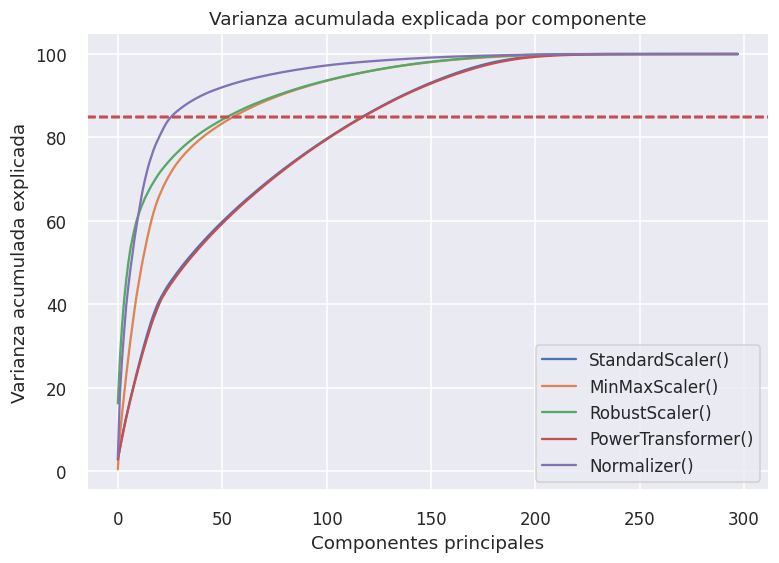

In [25]:
graficar_reducciones_con_preprocesamientos(X_df_numerico_poly, 95)

In [26]:
def graficar_reducciones_sin_preprocesamientos(df,var_deseada):
        fig, ax = plt.subplots(dpi=110)
        print("----------------------------------------------------------------------------")
        print("Buscando reducción de dimensionalidad sin preprocesamiento previo")
        svd = TruncatedSVD(n_components=df.shape[1]-1, n_iter=10, random_state=10)
        svd.fit(df)

        var_cumu = np.cumsum(svd.explained_variance_ratio_) * 100
        k = np.argmax(var_cumu > var_deseada)
        
        print("El numero minimo de componentes para explicar el",var_deseada, "% de la varianza es: " + str(k))
        ax.set_title('Varianza acumulada explicada por componente')
        ax.set_ylabel('Varianza acumulada explicada')
        ax.set_xlabel('Componentes principales')
    
        axes = ax.plot(var_cumu)
        ax.axhline(y=85, color="r", linestyle="--")


----------------------------------------------------------------------------
Buscando reducción de dimensionalidad sin preprocesamiento previo
El numero minimo de componentes para explicar el 95 % de la varianza es: 68


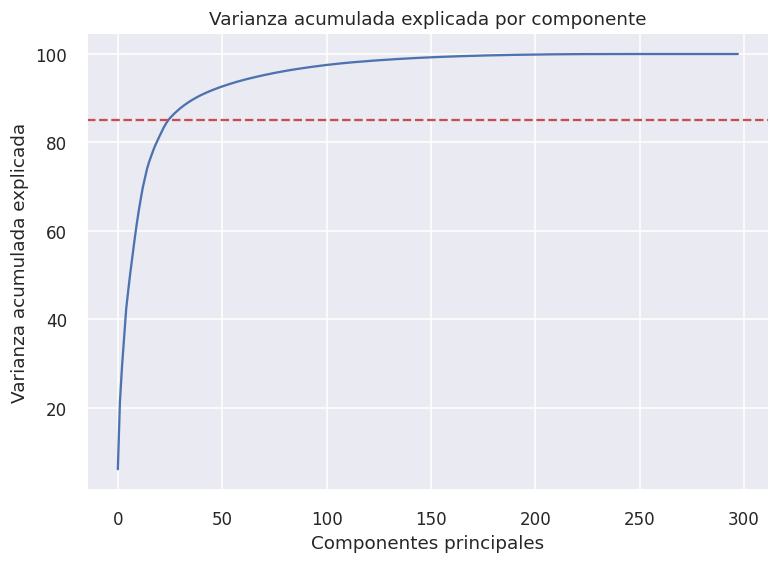

In [27]:
graficar_reducciones_sin_preprocesamientos(X_df_numerico_poly, 95)

In [28]:
svd = TruncatedSVD(n_components=68, n_iter=7, random_state=10)
X_df_expandido = pd.DataFrame(svd.fit_transform(X_df_numerico_poly))
print('Varianza explicada: %.10f' % svd.explained_variance_ratio_.sum())

Varianza explicada: 0.9491571259


## Revisemos con t-SNE

In [29]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init='pca', random_state=1001, perplexity=35, method='barnes_hut', n_iter=1000, verbose=1)
X_tsne = tsne.fit_transform(X_df_expandido)  

[t-SNE] Computing 106 nearest neighbors...
[t-SNE] Indexed 32561 samples in 0.292s...
[t-SNE] Computed neighbors for 32561 samples in 32.745s...
[t-SNE] Computed conditional probabilities for sample 1000 / 32561
[t-SNE] Computed conditional probabilities for sample 2000 / 32561
[t-SNE] Computed conditional probabilities for sample 3000 / 32561
[t-SNE] Computed conditional probabilities for sample 4000 / 32561
[t-SNE] Computed conditional probabilities for sample 5000 / 32561
[t-SNE] Computed conditional probabilities for sample 6000 / 32561
[t-SNE] Computed conditional probabilities for sample 7000 / 32561
[t-SNE] Computed conditional probabilities for sample 8000 / 32561
[t-SNE] Computed conditional probabilities for sample 9000 / 32561
[t-SNE] Computed conditional probabilities for sample 10000 / 32561
[t-SNE] Computed conditional probabilities for sample 11000 / 32561
[t-SNE] Computed conditional probabilities for sample 12000 / 32561
[t-SNE] Computed conditional probabilities for s

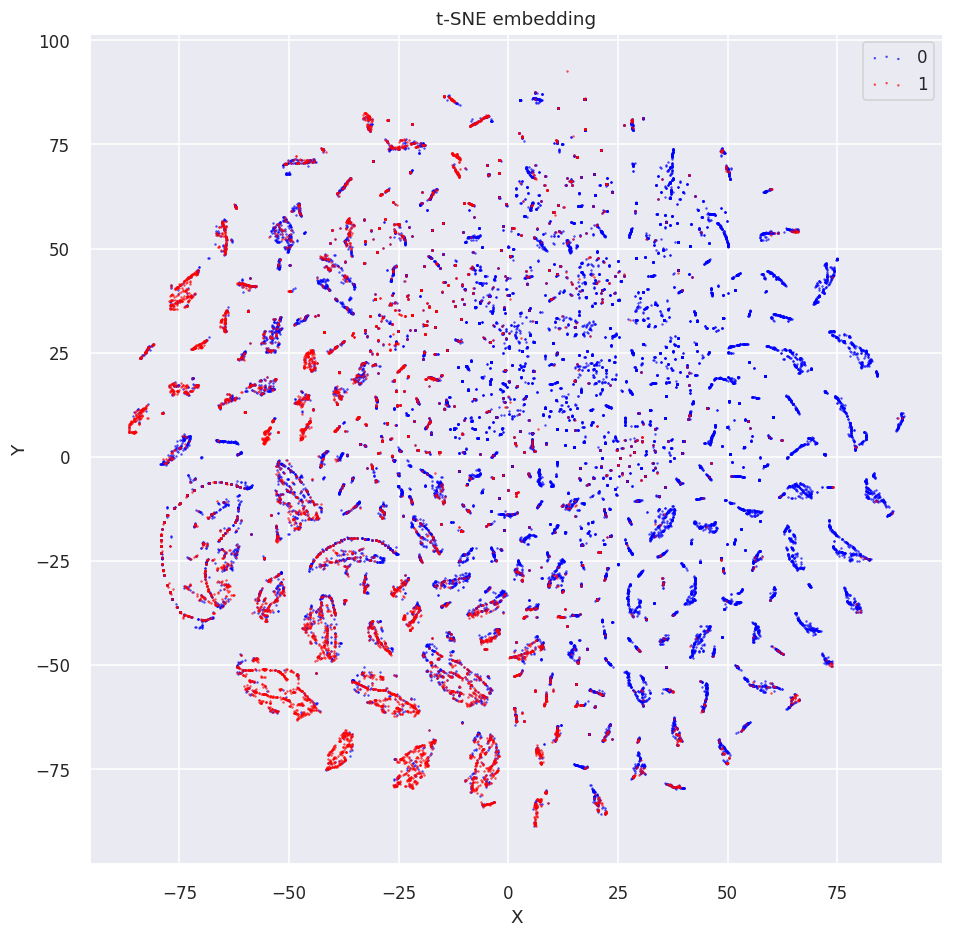

In [30]:
colors = ['blue', 'red']
target_names = np.unique(y_df_r)

plt.figure(2, figsize=(10, 10), dpi = 110)

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_tsne[y_df_r == i, 0], X_tsne[y_df_r == i, 1], color=color, s=1,
                alpha=.8, label=target_name, marker='.')
plt.legend(loc='best', shadow=False, scatterpoints=3)
plt.title('t-SNE embedding')
plt.xlabel('X')
plt.ylabel('Y')

plt.savefig('t-SNE-df-expandido', dpi=150)
plt.show()

## Construyendo la función para el preprocessing.py

In [31]:
def expansion(X_df, componentes_finales = 68):
    scaled = MinMaxScaler().fit_transform(X_df)
    print('MinMaxScaler aplicado...')
    X_df_numerico_scaled = pd.DataFrame(scaled, index=X_df_numerico.index, columns=X_df_numerico.columns)
    svd = TruncatedSVD(n_components=23, n_iter=7, random_state=10)
    X_df_numerico_scaled_svd = pd.DataFrame(svd.fit_transform(X_df_numerico_scaled))
    print('1° TruncatedSVD con 23 componentes finales se explica una varianza de: %.10f' % svd.explained_variance_ratio_.sum())
    X_df_numerico_poly = get_dataframe_polynomial(X_df_numerico_scaled_svd, 2, False)
    X_df_numerico_poly = filter_by_variance(X_df_numerico_poly, 0)
    print('PolynomialFeatures grado 2 aplicado se obtienen', len(X_df_numerico_poly.columns), 'nuevas componentes...')
    svd = TruncatedSVD(n_components=componentes_finales, n_iter=7, random_state=10)
    X_df_expandido = pd.DataFrame(svd.fit_transform(X_df_numerico_poly))
    print('2° TruncatedSVD con',  componentes_finales, 'componentes finales se explica una varianza de: %.10f' % svd.explained_variance_ratio_.sum())

In [32]:
df, df_for_prediction = obtener_datasets()
X_df_r, y_df_r = aplicar_preparacion(df)
X_df_numerico = conversion_numerica(X_df_r) 
X_df_expandido = expansion(X_df_numerico)

MinMaxScaler aplicado...
1° TruncatedSVD con 23 componentes finales se explica una varianza de: 0.9536277314
PolynomialFeatures grado 2 aplicado se obtienen 299 nuevas componentes...
2° TruncatedSVD con 68 componentes finales se explica una varianza de: 0.9491571259


In [33]:
df, df_for_prediction = obtener_datasets()
X_df_r, y_df_r = aplicar_preparacion(df)
X_df_numerico = conversion_numerica(X_df_r) 
X_df_expandido = expansion(X_df_numerico, componentes_finales = 15)

MinMaxScaler aplicado...
1° TruncatedSVD con 23 componentes finales se explica una varianza de: 0.9536277314
PolynomialFeatures grado 2 aplicado se obtienen 299 nuevas componentes...
2° TruncatedSVD con 15 componentes finales se explica una varianza de: 0.7407525167
